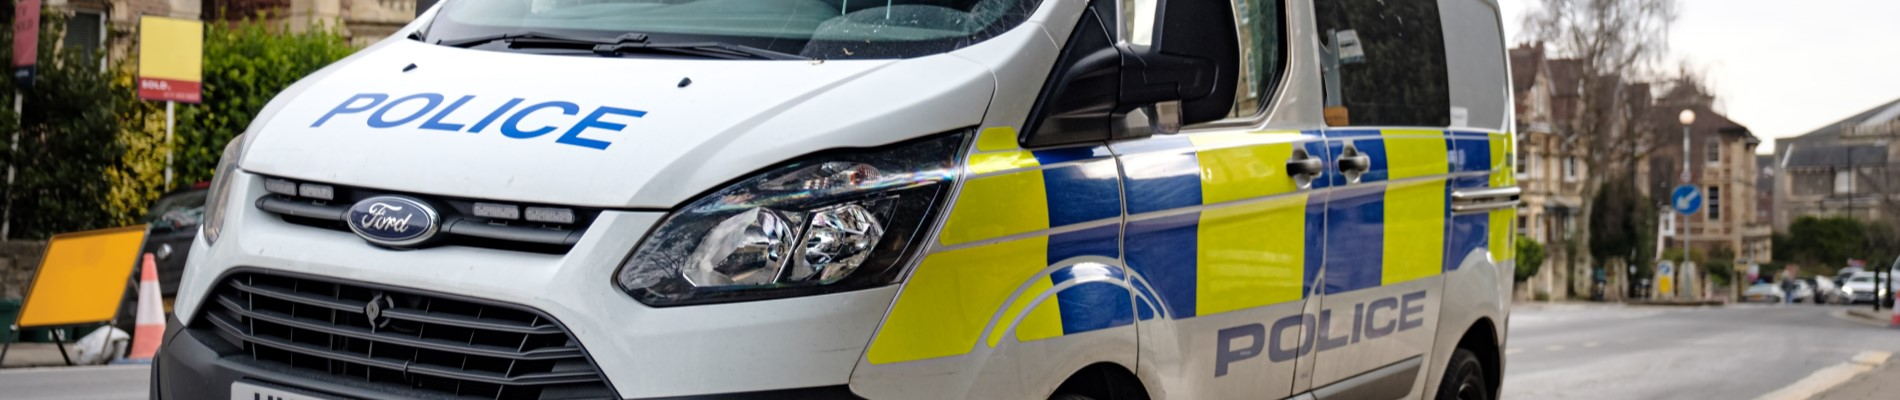

## Introduction

In this notebook we will try to answer the following questions:
1. What types of crime are most prevalent in the region?
2. Which areas in the region generate more crime?
3. How has the frequency of crime changed?

## Import
First we import the libraries we will need.

In [ ]:
import os # File manipulation
import pandas as pd # Data manipulation
import numpy as np # Mathematics
import matplotlib.pyplot as plt # Data plotting
import seaborn as sns # Data plotting

## Load
When data.police.uk serve the crime data, a zip file is provided which contains datasets for each month as CSV files. So we need to concatenate these contiguous CSV into a single cohesive DataFrame.

We make a sorted list of the file paths to each CSV.

In [ ]:
file_path_list = [] # The list to contain the CSV file paths.
# Walk through the input directory and loop through the sorted file names to 
# append the paths of the CSV files to the file path list.
for dirname, _, filenames in os.walk("/kaggle/input/"):
   for filename in sorted(filenames):
        file_path = os.path.join(dirname, filename)
        file_path_list.append(file_path)
file_path_list[:3] # We now have a list of sorted CSV file paths.

And then we make a DataFrame object to store our concatenated data. Because the file path list was ordered, the concatenated data retains its chronology by date.

In [ ]:
crime_data = pd.DataFrame(data=None) # Make a new DataFrame object.
# For each of the file paths in the file path list, read the CSV
# data and concatenate it to the DataFrame.
for file_path in file_path_list:
    crime_data = pd.concat([crime_data, pd.read_csv(file_path)])

## Clean
Let's examine the DataFrame and the nature of the values captured therein.

In [ ]:
crime_data.shape

In [ ]:
crime_data.info()

The DataFrame has several columns with missing values, and also several columns that are redundant to our analysis.

'Crime ID' is a one-way hash of the offence reference record, and 'Last outcome category' is a reference to whichever of the outcomes associated with the crime occurred most recently. Both contain values that are missing in equal measure from the entries in the DataFrame. On examination, it appears that a Crime ID is not recorded if no last outcome category has been attributed to the entry. Crime ID is redundant to our analysis and is a candidate for our list of columns to drop from the DataFrame.

'Reported by' and 'Falls within' are both the geographic police force that either supplied the data or is responsible for the data. They are both redundant to our analysis and are candidates for our list of columns to drop from the DataFrame.

'Context' is additional human-readable data about individual crimes. It contains no useful data, is therefore redundant to our analysis, and is a candidate for our list of columns to drop from the DataFrame.

In [ ]:
crime_data.sample(5)

Let's drop our candidate list of columns from the DataFrame.

In [ ]:
crime_data.drop(['Crime ID', 'Reported by', 'Falls within', 'Context'], axis=1, inplace=True)

The 'Last outcome category' can be made cohesive by filling the missing values with a simple 'Not stated'.

In [ ]:
crime_data.fillna(value={'Last outcome category': 'Not stated'}, inplace=True)

We want to perform our crime analysis by geography. 'Latitude', 'Longitude', 'LSOA code', and 'LSOA name' are now the only columns with missing values.

Missing values in 'Longitude' and 'Latitude' are not germane to our analysis right now, but they will be when we come to map our data to geospatial coordinates; and similarly for 'LSOA code'. However, missing values in 'LSOA name' are problematic, as the values in this column describe the area that the crime occurred.

So any missing values in these columns detract from our ability to understand the entry. As it would be misrepresentative to infer or approximate these values, the best solution would be to drop from our DataFrame any entry with a missing value.

In [ ]:
crime_data.dropna(axis=0, inplace=True)

We will re-label the columns to make our DataFrame more uniform.

In [ ]:
new_columns = {'Month': 'datetime',
               'Longitude': 'longitude',
               'Latitude': 'latitude',
               'Location': 'location',
               'LSOA code': 'lsoa_code',
               'LSOA name': 'lsoa_name',
               'Crime type': 'crime_type',
               'Last outcome category': 'last_outcome'}
crime_data.rename(columns=new_columns, inplace=True)

'Datetime' is a more useful type for the YYYY-MM format recorded in the entries. The date values recorded for each entry are truncated by data.police.uk to show the year and month only, to anonymise the data.

Our data spans from March 2018 to present.

In [ ]:
crime_data['datetime'] = pd.to_datetime(crime_data['datetime'],
                                        infer_datetime_format=True,
                                        errors='ignore')

Let's see how many unique values there are for the columns containing string data. We want to identify columns which contain values that could potentially become 'category' types. To help identify such columns we can look at the number of unique values, and also consider how we would submit an entry to our DataFrame if we were recording a crime; would we select one of these values from a small number of possibilities, or would we have license to be more descriptive?

In [ ]:
crime_data[['location', 'lsoa_code', 'lsoa_name', 'crime_type', 'last_outcome']].nunique()

The 14 unique values in 'crime_type' are Home Office Offence Codes (see database metadata). These values will be 'category' type.

In [ ]:
crime_data['crime_type'] = crime_data['crime_type'].astype('category')

In [ ]:
crime_data['crime_type'].describe()

With 26 unique values, 'last_outcome' will be 'category' type.

In [ ]:
crime_data['last_outcome'] = crime_data['last_outcome'].astype('category')

In [ ]:
crime_data['last_outcome'].describe()

For our analysis, we really want to identify which geographical area each entry belongs to. This information is actually encoded in the values in 'lsoa_name'. The composition of each of these values is the area name followed by a four-character code. Therefore, we can extract the area name by removing the four-character code.

We will make a new column for these values, called 'area'.

In [ ]:
# Replace the four-character code ###[A-Z] and the preceding white space with empty string,
# leaving just the area name. Assign this value to a new column, called 'area'.
crime_data['area'] = crime_data['lsoa_name'].str.replace('(\s\d{3}\D{1})', '', regex=True)
crime_data.sample(5)

In [ ]:
crime_data['area'].nunique()

There are 31 unique values for 'area', and it will be 'category' type.

In [ ]:
crime_data['area'] = crime_data['area'].astype('category')

In [ ]:
crime_data['area'].describe()

Lastly, we will rearrange the order of the columns for readability and to lend each entry more chronology with how the values are represented.

In [ ]:
crime_data = crime_data[['datetime',
                         'crime_type',
                         'location',
                         'area',
                         'lsoa_code',
                         'lsoa_name',
                         'latitude',
                         'longitude', 
                         'last_outcome']]
crime_data.sample(5)

In [ ]:
crime_data.info()

Our DataFrame is now more harmonious, descriptive, and cohesive, and we now have three categories from which to pivot the data.

## Explore

Let's see how many crimes have been reported by area for the whole DataFrame.

In [ ]:
crime_data.groupby('area').size().sort_values(ascending=False)

The bulk of the entries are in less than half of the areas. Upon investigation we can see that most of these areas do not belong to Devon and Cornwall and are not under the authority of Devon and Cornwall Police. Perhaps these are cases that have occurred outside of the force area but have investigative links to it?

We will compile a list of the areas outside of the Devon and Cornwall region and thus outside of the scope of our analysis. We will remove these categories and their subsequent entries from our DataFrame.

In [ ]:
outside_areas = ['Wandsworth',
                 'Isles of Scilly',
                 'Gwynedd',
                 'Ceredigion',
                 'West Somerset',
                 'County Durham',
                 'Taunton Deane',
                 'Copeland',
                 'West Dorset',
                 'Swansea',
                 'Purbeck',
                 'Maidstone',
                 'Poole',
                 'Isle of Anglesey',
                 'Conwy',
                 'Allerdale',
                 'Pembrokeshire',
                 'Powys',
                 'Neath Port Talbot',
                 'Wiltshire']
crime_data['area'].cat.remove_categories(outside_areas, inplace=True)
crime_data.groupby('area').size().sort_values(ascending=False)

Let's see how many crimes have been reported by type in all areas for the whole DataFrame.

In [ ]:
crime_data.groupby('crime_type').size().sort_values(ascending=False)

Finally, let's see the frequency of last outcomes assigned to each entry for the whole DataFrame.

In [ ]:
crime_data.groupby('last_outcome').size().sort_values(ascending=False)

In order to answer some of our questions that we posed in the Introduction, we will need to pivot our DataFrame so we can see the frequency of crime by date for each area.

We will use this pivot table to plot a set of heatmaps, one for each type of crime, describing the frequency of that crime by date for each area.

So let's start by building the pivot table.

In [ ]:
frequency_table = crime_data[['datetime', 'crime_type', 'area']] \
.pivot_table(index=['crime_type', 'area'],
             columns='datetime',
             aggfunc=np.size,
             fill_value=0)

A list of the crime types will be useful so we can iterate through the 'frequency_table' DataFrame. We will also order this list of crime types by frequency.

In [ ]:
crime_types = crime_data.groupby('crime_type').size().sort_values(ascending=False).index.to_list()

The 'datetime' type is quite verbose for an axis ticker in a plot, displaying both date *and* time. We will make our own list of tickers for the axis which will be formatted YYYY/MM.

In [ ]:
date_list = crime_data['datetime'].dt.strftime('%Y/%m').unique()

We will render a sequence of plots which will describe the frequency of each type of crime by date for each area.

We will use heatmaps because they are well suited to describing such granular data in the configuration we have chosen in our 'frequency_table' DataFrame.

In [ ]:
fig, ax = plt.subplots(len(crime_types), 1, figsize=(24, len(crime_types) * 9))
for index, crime in enumerate(crime_types): # Enumerate through our list of crime types.
    sns.heatmap(frequency_table.loc[crime, :],
                square=True,
                cbar_kws={'shrink': .35, 'label': 'Crime Frequency'},
                cmap='viridis',
                annot=True,
                annot_kws={'fontsize':9},
                fmt='',
                linewidth=1,
                linecolor='#222',
                robust=True,
                ax=ax[index])
    ax[index].set_title('Frequency of ' + crime.title() + ' for Devon and Cornwall', fontsize=32)
    ax[index].set_xlabel('Date', fontsize=24)
    ax[index].set_ylabel('Area', fontsize=24)
    ax[index].figure.axes[-1].yaxis.label.set_size(24)
    ax[index].set_xticklabels(date_list, rotation=45, horizontalalignment='right')
    ax[index].set_yticklabels(ax[index].get_yticklabels(), rotation=45, horizontalalignment='right')
plt.show()